In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
from scipy.stats import linregress
import logomaker
#import pingouin
from scipy.stats import pearsonr
import sys
%config InlineBackend.figure_format = 'retina'
np.random.seed(1234)
# Useful helper function
r_squared = lambda x,y: linregress(x.ravel().T, y.ravel().T)[2]**2

In [2]:
# Write function to compute bootstrap resampled uncertainties in correlation coefficient.
def my_rsquared(x,y, bootstrap_samples=100):
    """Returns R^2 and SE thereof based on bootstrap resampling"""
    r2 = pearsonr(x,y)[0]**2 # pingouin.corr(x, y).loc['pearson','r']**2
    N = len(x)
    assert len(x)==len(y), f'len(x)={len(x)} and len(y)={len(y)} are not the same.'
    r2s = np.zeros(bootstrap_samples)
    for i in range(bootstrap_samples):
        ix = np.random.choice(a=bootstrap_samples, size=bootstrap_samples, replace=True)
        r2s[i] = pearsonr(x[ix],y[ix])[0]**2 #pingouin.corr(x[ix], y[ix]).loc['pearson','r']**2
    dr2 = np.std(r2s)
    return r2, dr2

In [3]:
style_file_name = 'fig4.style'
s = """
axes.linewidth:     0.5     # edge linewidth
font.size:          7.0
axes.labelsize:     7.0  # fontsize of the x any y labels
xtick.labelsize:    7.0  # fontsize of the tick labels
ytick.labelsize:    7.0  # fontsize of the tick labels
legend.fontsize:      7.0
legend.borderpad:     0.2  # border whitespace
legend.labelspacing:  0.2  # the vertical space between the legend entries
legend.borderaxespad: 0.2  # the border between the axes and legend edge
legend.framealpha:    1.0 
"""
with open(style_file_name, 'w') as f:
    f.write(s)
    
plt.style.use(style_file_name)
plt.rc('font', family='sans-serif')
plt.rc('font', family='sans-serif')

In [4]:
from matplotlib.colors import TwoSlopeNorm, Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

def heatmap(values,
            alphabet,
            seq=None,
            seq_kwargs=None,
            ax=None,
            show_spines=False,
            cbar=True,
            cax=None,
            clim=None,
            clim_quantile=1,
            ccenter=None,
            cmap='coolwarm',
            cmap_size="5%",
            cmap_pad=0.1,
            first_pos=1):
    """
    Draw a heatmap illustrating an ``L`` x ``C`` matrix of values, where ``L`` is
    sequence length and ``C`` is the alphabet size.

    Parameters
    ----------
    values: (np.ndarray)
        Array of shape ``(L,C)`` that contains values to plot.

    alphabet: (str, np.ndarray)
        Alphabet name ``'dna'``, ``'rna'``, or ``'protein'``, or 1D array
        containing characters in the alphabet.

    seq: (str, None)
        The sequence to show, if any, using dots plotted on top of the heatmap.
        Must have length ``L`` and be comprised of characters in ``alphabet``.

    seq_kwargs: (dict)
        Arguments to pass to ``Axes.scatter()`` when drawing dots to illustrate
        the characters in ``seq``.

    ax: (matplotlib.axes.Axes)
        The ``Axes`` object on which the heatmap will be drawn.
        If ``None``, one will be created. If specified, ``cbar=True``,
        and ``cax=None``, ``ax`` will be split in two to make room for a
        colorbar.

    show_spines: (bool)
        Whether to show spines around the edges of the heatmap.

    cbar: (bool)
        Whether to draw a colorbar next to the heatmap.

    cax: (matplotlib.axes.Axes, None)
        The ``Axes`` object on which the colorbar will be drawn,
        if requested. If ``None``, one will be created by splitting
        ``ax`` in two according to ``cmap_size`` and ``cmap_pad``.

    clim: (list, None)
        List of the form ``[cmin, cmax]``, specifying the maximum ``cmax``
        and minimum ``cmin`` values spanned by the colormap. Overrides
        ``clim_quantile``.

    clim_quantile: (float)
        Must be a float in the range [0,1]. ``clim`` will be automatically
        chosen to include this central quantile of values.

    ccenter: (float)
        Value at which to position the center of a diverging
        colormap. Setting ``ccenter=0`` often makes sense.

    cmap: (str, matplotlib.colors.Colormap)
        Colormap to use.

    cmap_size: (str)
        Fraction of ``ax`` width to be used for the colorbar. For formatting
        requirements, see the documentation for
        ``mpl_toolkits.axes_grid1.make_axes_locatable()``.

    cmap_pad: (float)
        Space between colorbar and the shrunken heatmap ``Axes``. For formatting
        requirements, see the documentation for
        ``mpl_toolkits.axes_grid1.make_axes_locatable()``.
        
    first_pos: (int)
        Value of first position. 

    Returns
    -------
    ax: (matplotlib.axes.Axes)
        ``Axes`` object containing the heatmap.

    cb: (matplotlib.colorbar.Colorbar, None)
        Colorbar object linked to ``ax``, or ``None`` if no colorbar was drawn.
    """
    #alphabet = validate_alphabet(alphabet)
    L, C = values.shape

    # Set extent
    #xlim = [-.5, L - .5]
    xlim = [first_pos - .5, L + first_pos - .5]
    ylim = [-.5, C - .5]

    # If wt_seq is set, validate it.
    #if seq:
    #    seq = validate_seqs(seq, alphabet)

    # Set color lims to central 95% quantile
    if clim is None:
        vals = values.ravel()
        vals = vals[np.isfinite(vals)]
        clim = np.quantile(vals, q=[(1 - clim_quantile) / 2,
                                    1 - (1 - clim_quantile) / 2])

    # Create axis if none already exists
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    # Needed to center colormap at zero
    if ccenter is not None:

        # Reset ccenter if is not compatible with clim
        if (clim[0] > ccenter) or (clim[1] < ccenter):
            ccenter = 0.5 * (clim[0] + clim[1])

        norm = TwoSlopeNorm(vmin=clim[0], vcenter=ccenter, vmax=clim[1])

    # Otherwise, use uncentered colormap
    else:
        norm = Normalize(vmin=clim[0], vmax=clim[1])

    # Plot heatmap
    #x_edges = np.arange(L + 1) - .5
    x_edges = np.arange(L + 1) + first_pos - 0.5
    y_edges = np.arange(C + 1) - .5
    im = ax.pcolormesh(x_edges,
                       y_edges,
                       values.T,
                       shading='flat',
                       cmap=cmap,
                       clim=clim,
                       norm=norm)

    # Mark wt sequence
    _ = np.newaxis
    if seq:
        
        seq = [seq]
        # Set marker style
        if seq_kwargs is None:
            seq_kwargs = {'marker': '.', 'color': 'k', 's': 2}

        # Get xy coords to plot
        seq_arr = np.array(list(seq[0]))
        xy = np.argwhere(seq_arr[:, _] == alphabet[_, :])

        # Mark sequence
        ax.scatter(xy[:, 0] + first_pos, xy[:, 1], **seq_kwargs)
        #pdb.set_trace()

    # Style plot
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_yticks(range(C))
    ax.set_yticklabels(alphabet, ha='center')
    ax.invert_yaxis()

    if not show_spines:
        for loc, spine in ax.spines.items():
            spine.set_visible(False)

    # Create colorbar if requested, make one
    if cbar:
        if cax is None:
            cax = make_axes_locatable(ax).new_horizontal(size=cmap_size,
                                                         pad=cmap_pad)
            fig.add_axes(cax)
        cb = plt.colorbar(im, cax=cax)

        # Otherwise, return None for cb
    else:
        cb = None

    return ax, cb

In [5]:
# Load ABeta plot data
abeta_npz = np.load('../old/fig4_abeta.npz',  allow_pickle=True)
ABeta_theta_values = abeta_npz['ABeta_theta_values']
alphabet_ABeta=abeta_npz['alphabet_Abeta']
seq_ABeta = str(abeta_npz['seq_ABeta'])
phi_test_ABeta = abeta_npz['phi_test_ABeta']
phi_lim_ABeta = abeta_npz['phi_lim_ABeta']
phi_grid_ABeta = abeta_npz['phi_grid_ABeta']
yhat_grid_ABeta = abeta_npz['yhat_grid_ABeta']
yq_grid_ABeta = abeta_npz['yq_grid_ABeta']
yhat_test_ABeta = abeta_npz['yhat_test_ABeta']
r2_ABeta = abeta_npz['r2_ABeta']
I_var_ABeta= abeta_npz['I_var_ABeta']
dI_var_ABeta=abeta_npz['dI_var_ABeta']
I_pred_ABeta=abeta_npz['I_pred_ABeta']
dI_pred_ABeta = abeta_npz['dI_pred_ABeta']
x_test_ABeta = abeta_npz['x_test_ABeta']
y_test_ABeta = abeta_npz['y_test_ABeta']             

In [6]:
# Get indices for aa order used in Seuma et al. and Bolognesi et al.
alphabet = np.array(list('GAVLMIFYWKRDESTCNQHP*'))
aix = alphabet[:-1].argsort()
sorted_aa = alphabet[aix]
aixx = aix.argsort()
sorted_aa[aixx]
aixx = np.append(aixx,int(20))
aixx

array([ 5,  0, 17,  9, 10,  7,  4, 19, 18,  8, 14,  2,  3, 15, 16,  1, 11,
       13,  6, 12, 20])

In [7]:
# Load TDP plot data
TDP_npz = np.load('../old/fig4_TDP.npz',  allow_pickle=True)
TDP_theta_values = TDP_npz['TDP_theta_values']
alphabet_TDP=TDP_npz['alphabet_TDP']
seq_TDP = str(TDP_npz['seq_TDP'])
phi_test_TDP = TDP_npz['phi_test_TDP']
phi_lim_TDP = TDP_npz['phi_lim_TDP']
phi_grid_TDP = TDP_npz['phi_grid_TDP']
yhat_grid_TDP = TDP_npz['yhat_grid_TDP']
yq_grid_TDP = TDP_npz['yq_grid_TDP']
yhat_test_TDP = TDP_npz['yhat_test_TDP']
r2_TDP = TDP_npz['r2_TDP']
I_var_TDP= TDP_npz['I_var_TDP']
dI_var_TDP=TDP_npz['dI_var_TDP']
I_pred_TDP=TDP_npz['I_pred_TDP']
dI_pred_TDP = TDP_npz['dI_pred_TDP']
x_test_TDP = TDP_npz['x_test_TDP']
y_test_TDP = TDP_npz['y_test_TDP']   

In [8]:
# Model predictions for wt sequences
phi_wt_ABeta = 1.1025
yhat_wt_ABeta = 0.12027
phi_wt_TDP = -0.01602
yhat_wt_TDP = -0.0022342

Aβ parameters: 367/882 (41.6%) are undetermined.
TDP-43 parameters: 437/1764 (24.8%) are undetermined.


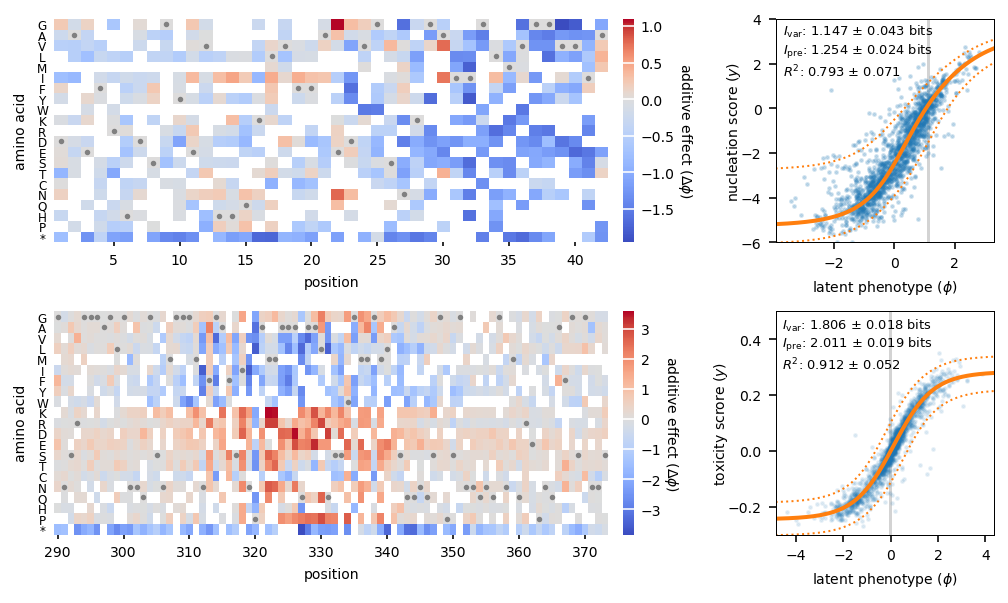

In [9]:
fig = plt.figure(figsize=[7.0, 4.20])

plt.style.use(style_file_name)
gs = fig.add_gridspec(2, 3)
# Define panels
ax_a = fig.add_subplot(gs[0, 0:2])
ax_b = fig.add_subplot(gs[0, 2])
ax_c = fig.add_subplot(gs[1, 0:2])
ax_d = fig.add_subplot(gs[1, 2])

alpha = 0.1

# Panel A: Heatmap ABeta
ax = ax_a
_, cb = heatmap(ABeta_theta_values[:,aixx], 
                alphabet=alphabet,
                ax=ax, 
                seq=seq_ABeta, 
                seq_kwargs={'s':3, 'color':'gray'},
                ccenter=0,
                cmap_size="2%",
                cmap='coolwarm',
                first_pos=1)
ax.set_ylabel('amino acid')
ax.set_xlabel('position')

# Print number of total and undetermined parameters
num_nan = (~np.isfinite(ABeta_theta_values)).sum().sum()
num_tot = len(ABeta_theta_values.ravel())
pct_nan = 100*num_nan/num_tot
print(f'Aβ parameters: {num_nan}/{num_tot} ({pct_nan:.1f}%) are undetermined.')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(rotation=0, size=2)
ax.tick_params(axis='y', size=0, pad=6, labelsize=6)
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=10, color='white')
# cb.set_ticks([-2, -1.5, -.5, 0, .5, 1.0])
cb.set_label('additive effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center')

# Panel B: GE plot ABeta
phi_ticks = [-4,-2,0,2,4]
yticks = [-6,-4,-2,0,2,4]
ylim = [-6, 4]
#xlim = [-3,3]

## Set phi lims and create grid in phi space
ax = ax_b
ax.scatter(phi_test_ABeta, 
           y_test_ABeta, 
           s=2,
           alpha=alpha+0.1,
           color='C0',
           label='test data')
ax.set_xticks(phi_ticks)
ax.set_yticks(yticks)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('nucleation score ($y$)', labelpad=-1)
ax.set_xlim(phi_lim_ABeta)
ax.set_ylim(ylim)
#ax.set_xlim(xlim)

ax.plot(phi_grid_ABeta, yhat_grid_ABeta,    color='C1',  alpha=1, linewidth=2, linestyle='-', label='$\hat{y}$')
ax.plot(phi_grid_ABeta, yq_grid_ABeta[:,0], color='C1', alpha=1, linewidth=1, linestyle=':',  label='95% CI')
ax.plot(phi_grid_ABeta, yq_grid_ABeta[:,1], color='C1', alpha=1, linewidth=1,linestyle=':')

# draw wt phi
ax.axvline(phi_wt_ABeta, color='lightgray', zorder=-1)


###  Compute r2
r2_ABeta, dr2_ABeta = my_rsquared(y_test_ABeta, yhat_test_ABeta)

ax.text(x=-3.7, y=3.8, fontsize=6.5, ha='left', va='top',
        s=f'$I_{{\\rm var}}$: {I_var_ABeta:.3f} $\pm$ {dI_var_ABeta:.3f} bits\n' +
          f'$I_{{\\rm pre}}$: {I_pred_ABeta:.3f} $\pm$ {dI_pred_ABeta:.3f} bits\n' +
          f'$R^2$: {r2_ABeta:.3f} $\pm$ {dr2_ABeta:.3f}');


# Panel C: Heatmap TDP-43
ax = ax_c
_, cb = heatmap(TDP_theta_values[:,aixx], 
                alphabet=alphabet,
                ax=ax, 
                seq=seq_TDP,
                seq_kwargs={'s':3, 'color':'gray'},
                ccenter=0,
                cmap_size="2%",
                cmap='coolwarm',
                first_pos=290)
ax.set_ylabel('amino acid')
ax.set_xlabel('position')

# Print number of total and undetermined parameters
num_nan = (~np.isfinite(TDP_theta_values)).sum().sum()
num_tot = len(TDP_theta_values.ravel())
pct_nan = 100*num_nan/num_tot
print(f'TDP-43 parameters: {num_nan}/{num_tot} ({pct_nan:.1f}%) are undetermined.')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(rotation=0, size=2)
ax.tick_params(axis='y', size=0, pad=6, labelsize=6)
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=10, color='white')
cb.set_label('additive effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center')

# Panel D: GE plot TDP-43
phi_ticks = [-4,-2,0,2,4]
yticks = [-0.2,0.0,0.2,0.4]
ylim = [-0.3, 0.5]

ax = ax_d
# Select 2000 random point for better visuzlization
ix = np.random.choice(y_test_TDP.shape[0], 2000, replace=False)

ax.scatter(phi_test_TDP[ix], 
           y_test_TDP[ix], 
           s=2,
           alpha=alpha,
           color='C0',
           label='test data')
ax.set_xticks(phi_ticks)
ax.set_yticks(yticks)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('toxicity scrore ($y$)', labelpad=-1)
ax.set_xlim(phi_lim_TDP)
ax.set_ylim(ylim)

ax.plot(phi_grid_TDP, yhat_grid_TDP,    color='C1',  alpha=1, linewidth=2, linestyle='-', label='$\hat{y}$')
ax.plot(phi_grid_TDP, yq_grid_TDP[:,0], color='C1', alpha=1, linewidth=1, linestyle=':',  label='95% CI')
ax.plot(phi_grid_TDP, yq_grid_TDP[:,1], color='C1', alpha=1, linewidth=1, linestyle=':')



## Compute r2
r2_TDP, dr2_TDP = my_rsquared(y_test_TDP, yhat_test_TDP)

ax.text(x=-4.6, y=.48, fontsize=6.5, ha='left', va='top',
        s=f'$I_{{\\rm var}}$: {I_var_TDP:.3f} $\pm$ {dI_var_TDP:.3f} bits\n' +
          f'$I_{{\\rm pre}}$: {I_pred_TDP:.3f} $\pm$ {dI_pred_TDP:.3f} bits\n' +
          f'$R^2$: {r2_TDP:.3f} $\pm$ {dr2_TDP:.3f}');

# draw wt phi
ax.axvline(phi_wt_TDP, color='lightgray', zorder=-1)

fig.tight_layout(w_pad=2)
fig.savefig('fig4_ipynb.png', dpi=400, facecolor='w')